In [1]:
#Reloads the lab.py and crystals.py modules to update any changes (after saving)
#If a new method or object is created, autoreload doesn't work and the 
#kernel needs to be closed and halted after saving and making a 'checkpoint'
#in this notebook

%load_ext autoreload
%autoreload 2

In [2]:
import ipas 
import numpy as np
import dask
from dask_jobqueue import SLURMCluster
from distributed import LocalCluster
from dask.distributed import Client, progress
from dask import delayed
from dask import dataframe as dd
import functools
import sys
import ast
from struct import *
import pickle
import glob
import random
import pandas as pd
import time
from dask.distributed import as_completed
from joblib import Parallel, delayed, parallel_backend
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors

In [ ]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (7,7),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)

In [15]:
cluster = SLURMCluster(
    queue='batch',
    walltime='04-23:00:00',
    cores=1,
    memory='20000MiB', #1 GiB = 1,024 MiB
    processes=1)

#cluster.adapt(minimum=3, maximum=20)
cluster.scale(35)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [17]:
client = Client(cluster)

In [20]:
client

Client Scheduler: tcp://169.226.65.160:33725 Dashboard: http://169.226.65.160:36451/status,Cluster Workers: 35 Cores: 35 Memory: 733.95 GB


In [21]:
files = [f for f in glob.glob("../instance_files/createdb_iceagg_flat*")]

In [22]:
%%time 
data = []
for file in files:
    print(file)
    #dictionary = pickle.load(f)
    data.append(pd.read_pickle(file, None))
datapd = [pd.DataFrame(i) for i in data]
df = pd.concat(datapd, axis=0, ignore_index=True)
df['agg_r'] = np.power((np.power(df['a'], 2) * df['c']), (1./3.))
df['agg_r'] = df['agg_r'][df.agg_r < 5000]
df['shape'] = df.apply(lambda row: 'prolate' if (row.b - row.c) <= (row.a - row.b) else 'oblate', axis=1)
df['agg_phi'] = df.c/df.a

../instance_files/createdb_iceagg_flat_r500_1000
../instance_files/createdb_iceagg_flat_r90_400
../instance_files/createdb_iceagg_flat_r40_80
../instance_files/createdb_iceagg_flat_r10_30
../instance_files/createdb_iceagg_flat_r1_4
../instance_files/createdb_iceagg_flat_r5_9
CPU times: user 8min 4s, sys: 6min 20s, total: 14min 24s
Wall time: 18min 41s


In [87]:
agg_stats = df['agg_r'].describe().round(2)
agg_stats

count    4872000.00
mean        4012.09
std         8982.76
min            1.73
25%           98.72
50%          629.81
75%         3974.26
max       138997.54
Name: agg_r, dtype: float64

In [373]:
df['agg_r'] = df['agg_r'][df.agg_r < 5000]
stats = df['agg_r'].describe().round(2)
stats
#78% of db

count    4214075.00
mean         823.57
std         1221.32
min            1.47
25%           53.33
50%          254.56
75%          920.76
max         4999.99
Name: agg_r, dtype: float64

In [360]:
#df['agg_phi'] = df.apply(lambda x: x.c/x.a if x.mono_phi<1.0 else x.a/x.c, axis=1)
%time df['shape'] = df.apply(lambda row: 'prolate' if (row.b - row.c) <= (row.a - row.b) else 'oblate', axis=1)

In [364]:
agg_stats = df['agg_phi'].describe().round(3)
agg_stats

count    4872000.000
mean           0.322
std            0.237
min            0.005
25%            0.095
50%            0.279
75%            0.538
max            0.977
Name: agg_phi, dtype: float64

# MAIN

In [23]:
ch_dist='gamma'         #anything other than gamma uses the characteristic from the best distribution pdf (lowest SSE)
rand_orient = False      #randomly orient the seed crystal and new crystal: uses first random orientation
save_plots = False  
phi_factor=10
r_factor=2

In [24]:
def main():
    
    output = np.empty((agg_phi_bins,agg_r_bins),dtype=object)
    hold_clusters  = np.empty((agg_phi_bins,agg_r_bins,nclusters), dtype=object)
    a  = np.empty((agg_phi_bins,agg_r_bins,nclusters), dtype=object)
    c = np.empty((agg_phi_bins,agg_r_bins,nclusters), dtype=object)

    res, phi_bins = pd.qcut(df.agg_phi, agg_phi_bins, retbins=True)

    for i in range(agg_phi_bins):
        #print('agg phi range: ', phi_bins[i], phi_bins[i+1])
        #return a df that only queries within an aspect ratio bin
        df_phi = df[(df.agg_phi > phi_bins[i]) & (df.agg_phi < phi_bins[i+1])]  
        #to ensure at least 2 crystals within agg since ncrystals=1 not in db
        #now break that aspect ratio bin into 20 equal r bins
        
        res, r_bins = pd.qcut(df_phi.agg_r, agg_r_bins, retbins=True)
        for r in range(agg_r_bins):   #agg r
               
            #print('r = ', r_bins[r], r_bins[r+1])
            df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
            #plt.hist(df_r.mono_phi)
            #plt.xscale('log')
            #plt.show()

            samples = df_r.sample(nclusters)
            for n, agg in enumerate(samples.itertuples()):

                phi_range = np.logspace(np.log(agg.mono_phi/phi_factor)/np.log(10),
                                        np.log(agg.mono_phi*phi_factor)/np.log(10), 20)
                mono_phi = random.choice(phi_range)
                mono_phi = 0.01 if mono_phi < 0.01 else mono_phi
                mono_phi = 70 if mono_phi > 70 else mono_phi

                r_range = np.logspace(np.log(agg.mono_r/r_factor)/np.log(10),\
                                      np.log(agg.mono_r*r_factor)/np.log(10),20)
                mono_r = random.choice(r_range)
                mono_r = 1000 if mono_r>1000 else mono_r
                mono_r = 1 if mono_r<1 else mono_r
                
                a[i,r,n] = (mono_r ** 3 / mono_phi) ** (1. / 3.)
                c[i,r,n] = mono_phi * a[i,r,n]
#               print('phi range', agg.mono_phi, phi_range[0], phi_range[-1], phi_range)
#               print('r range: ', agg.mono_r, r_range[0], r_range[-1], r_range)
                
                hold_clusters[i,r,n] = ipas.Cluster_Calculations(agg)

            #ipas.collect_clusters(a[i,r,:], c[i,r,:], hold_clusters[i,r,:], rand_orient=rand_orient)
            output[i,r] = dask.delayed(ipas.collect_clusters)(a[i,r,:], c[i,r,:],
                                                                 hold_clusters[i,r,:], rand_orient=rand_orient)

    return output, hold_clusters
    

In [25]:
def compute():
    agg_as = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    agg_bs = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    rzs = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    phi2Ds = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    cplxs = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    dds = np.empty((agg_phi_bins, agg_r_bins, nclusters))

    gather = client.compute([*output.tolist()]) 
    gather = client.gather(gather)
    gather = np.array(gather)
    print(np.shape(gather))
    agg_as = gather[:,:,0,:]
    agg_bs = gather[:,:,1,:]
    agg_cs = gather[:,:,2,:]
    phi2Ds = gather[:,:,3,:]
    cplxs = gather[:,:,4,:] 
    dds = gather[:,:,5,:]

    print('DONE!')
    return agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds

In [ ]:
if __name__ == '__main__':
    
    agg_phi_bins = 20
    agg_r_bins = 20
    nclusters = 300

    output, hold_clusters = main()
    agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds= compute()
    results = {'agg_as': agg_as, 'agg_bs':agg_bs, 'agg_cs':agg_cs, 'phi2Ds':phi2Ds, \
               'cplxs':cplxs, 'dds':dds}
   
    filename = '../instance_files/pulled_clusters_iceagg_flat'
    filehandler = open(filename, 'wb')
    pickle.dump(hold_clusters, filehandler)
    filehandler.close()
    
    filename = '../instance_files/instance_db_iceagg_flat'
    filehandler = open(filename, 'wb')
    pickle.dump(results, filehandler)
    filehandler.close()
    print('finished!')

In [48]:
def query_ncrystals(df_phi, r_bins):
    avg_ncrystals = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_ncrystals.append(df_r.ncrystals.mean())
    return avg_ncrystals


In [49]:
def avg_cplx(df_phi, r_bins):
    avg_cplx = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.cplx > r_bins[r]) & (df_phi.cplx < r_bins[r+1])]
        avg_cplx.append(np.mean(df_r.cplx))
    return avg_cplx


In [50]:
def oblate_prolate(df_phi, r_bins):
    shape = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1]) & (df_phi.ncrystals > 2)]
        oblates = df_r['shape'][df_r['shape'] == 'oblate'].count()
        prolates = df_r['shape'][df_r['shape'] == 'prolate'].count()
        shape.append(oblates-prolates)
        return shape

In [51]:
def plate_columns_agg(df_phi, r_bins):
    agg_mono_phi = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1]) & (df_phi.ncrystals > 2)]
        agg_mono_plates = df_r['mono_phi'][df_r['mono_phi'] < 1.0].count()
        agg_mono_col = df_r['mono_phi'][df_r['mono_phi'] > 1.0].count()
        agg_mono_phi.append(agg_mono_plates - agg_mono_col)
    return agg_mono_phi


In [65]:
def average_radius(df_phi, r_bins):
    avg_radius = []
    for r in range(len(r_bins)-1):
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_radius.append(np.mean(df_r.mono_r))
    return avg_radius

In [66]:
#RAND
res, phi_bins_rand = pd.qcut(df.agg_phi, 20, retbins=True)
#print(phi_bins)
phi_bin_labs = []
avg_ncrystals=np.empty((len(phi_bins_rand)-1,len(phi_bins_rand)-1))
avg_cplxs=np.empty((len(phi_bins_rand)-1,len(phi_bins_rand)-1))
all_r_bins= np.empty((len(phi_bins_rand),len(phi_bins_rand)))
shape= np.empty((len(phi_bins_rand)-1,len(phi_bins_rand)-1))
agg_mono_phi = np.empty((len(phi_bins_rand)-1,len(phi_bins_rand)-1))
avg_radius = np.empty((len(phi_bins_rand)-1,len(phi_bins_rand)-1))

for i in range(agg_phi_bins):
    print('i = ', i)
    phi_bin_labs.append('[%.3f-%.3f]' %(phi_bins_rand[i],phi_bins_rand[i+1]))
    #return a df that only queries within an aspect ratio bin
    df_phi = df[(df.agg_phi > phi_bins_rand[i]) & (df.agg_phi < phi_bins_rand[i+1])]
    #now break that aspect ratio bin into 20 equal r bins
    res, r_bins = pd.qcut(df_phi.agg_r, 20, retbins=True)
    all_r_bins[i,:] = r_bins
    
    #now use those r bins from the output of queried r and phi to find # of monomers per bin
    avg_ncrystals[i,:] = query_ncrystals(df_phi, r_bins)
    avg_cplxs[i,:] = avg_cplx(df_phi, r_bins)
    shape[i,:] = oblate_prolate(df_phi, r_bins)
    agg_mono_phi[i,:] = plate_columns_agg(df_phi, r_bins)
    avg_radius[i,:] = average_radius(df_phi, r_bins)
    

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16
i =  17
i =  18
i =  19


In [59]:
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.cm.seismic
cb_range = max(abs(np.amin(avg_ncrystals)), np.amax(avg_ncrystals))
divnorm = colors.DivergingNorm(vmin=-cb_range, vcenter=0, vmax=cb_range)

#norm = matplotlib.colors.Normalize(vmin=np.amin(shape), vmax=np.amax(shape))
for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):

        if r != 0:
            if shape[i,r] == 'p': 
                plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(divnorm(avg_ncrystals[i,r])),edgecolor='k')
            else:
                 plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(divnorm(avg_ncrystals[i,r])),edgecolor='k')
        else:
            if shape[i,r] == 'p':
                plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(divnorm(avg_ncrystals[i,r])), edgecolor='k')
            else:
                plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(divnorm(avg_ncrystals[i,r])), edgecolor='k')
                
    
plt.yscale('log')
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center",fontsize=16,family='serif')
plt.ylabel("Aggregate Radius Bins",fontsize=16,family='serif')
plt.xlabel("Aggregate Aspect Ratio ($\phi$) bins",fontsize=16,family='serif')  
cb = plt.cm.ScalarMappable(norm=divnorm, cmap=cmap)
cbar = plt.colorbar(cb)
#cbar.ax.set_ylabel('Average # of monomers per bin', fontsize=16, family='serif')
#cbar.ax.set_ylabel('Average # of monomers per bin', fontsize=16, family='serif')
#plt.title('Quasi-Horizontal Orientation',fontsize=16, family='serif')
plt.title('Flat Orientation',fontsize=16, family='serif')
plt.tight_layout()
#plt.savefig('bins_rand_meanmono_r_5000rad_logy.pdf')


i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19
Error in callback <function flush_figures at 0x7f7c1d7db1e0> (for post_execute):


KeyboardInterrupt: 

i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19


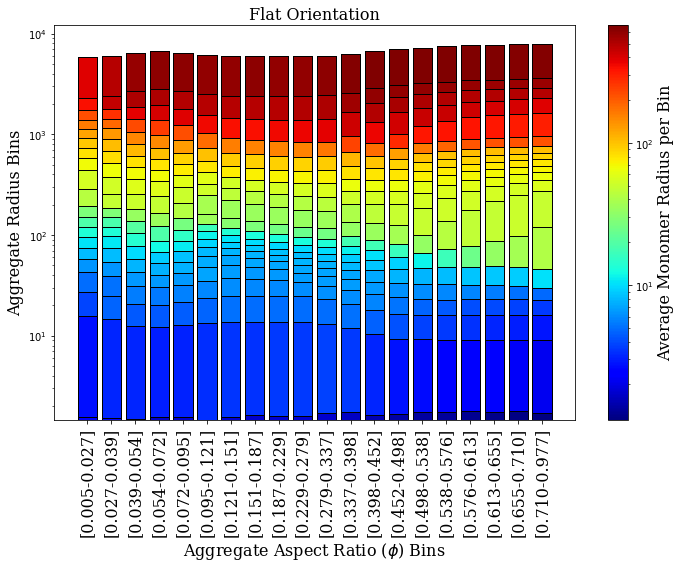

In [84]:
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.cm.jet
variable = avg_radius
norm = matplotlib.colors.LogNorm(vmin=np.amin(variable), vmax=np.amax(variable))

#norm = matplotlib.colors.Normalize(vmin=np.amin(shape), vmax=np.amax(shape))
for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):

        if r != 0:
            if shape[i,r] == 'p': 
                plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r])),edgecolor='k')
            else:
                 plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r])),edgecolor='k')
        else:
            if shape[i,r] == 'p':
                plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')
            else:
                plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')
                
    
plt.yscale('log')
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center",fontsize=16,family='serif')
plt.ylabel("Aggregate Radius Bins",fontsize=16,family='serif')
plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins",fontsize=16,family='serif')  
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(cb)
cbar.ax.set_ylabel('Average Monomer Radius per Bin', fontsize=16, family='serif')
#plt.title('Quasi-Horizontal Orientation',fontsize=16, family='serif')
plt.title('Flat Orientation',fontsize=16, family='serif')
plt.tight_layout()
#plt.savefig('bins_rand_meanmono_r_5000rad_logy.pdf')


i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19


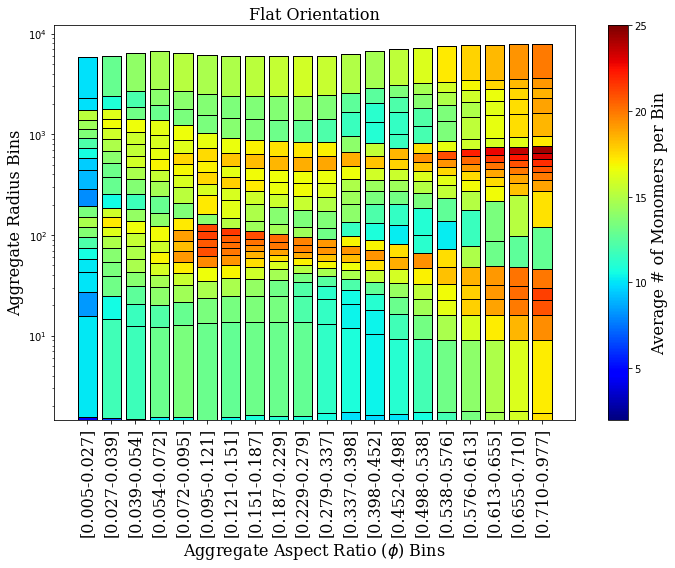

In [89]:
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.cm.jet
variable = avg_ncrystals
norm = matplotlib.colors.Normalize(vmin=2, vmax=25)

for i in range(agg_phi_bins): 
    print('i= ', i)
    for r in range(agg_r_bins):

        if r != 0:
            if shape[i,r] == 'p': 
                plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r])),edgecolor='k')
            else:
                 plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(norm(variable[i,r])),edgecolor='k')
        else:
            if shape[i,r] == 'p':
                plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')
            else:
                plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(norm(variable[i,r])), edgecolor='k')
                
    
plt.yscale('log')
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center",fontsize=16,family='serif')
plt.ylabel("Aggregate Radius Bins",fontsize=16,family='serif')
plt.xlabel("Aggregate Aspect Ratio ($\phi$) Bins",fontsize=16,family='serif')  
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(cb, format='%d')
cbar.ax.set_ylabel('Average # of Monomers per Bin', fontsize=16, family='serif')
#plt.title('Quasi-Horizontal Orientation',fontsize=16, family='serif')
plt.title('Flat Orientation',fontsize=16, family='serif')
plt.tight_layout()
#plt.savefig('bins_rand_meanmono_r_5000rad_logy.pdf')
